# データで見る ゲンロン 大森望 SF創作講座 2018

[ゲンロン 大森望 SF創作講座 第3期](http://school.genron.co.jp/works/sf/2018/) も残すところ最終課題のみとなった。  
最終課題は「ゲンロンSF新人賞」と題されており他とは少し毛色が違うので、通常課題はすべて出揃ったことになる。  
明日からは[第4期の募集も始まる](https://twitter.com/genronschool/status/1110500492763762688)とのことなので、受講を迷っている方に向けてSF創作講座第3期のデータを見てみようと思う。

目次は次のとおりである。

- 課題提出数の推移
- 選出・得点の機会
- 梗概の文字数
- 受講生勝手にランキング

データは、[fuji-nakahara/genron-sf-app](https://github.com/fuji-nakahara/genron-sf-app) を用いて [超・SF作家育成サイト](http://school.genron.co.jp/works/sf/) をスクレイピングしたものを用いる。

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
%config InlineBackend.figure_formats = {'png', 'retina'}
sns.set()

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%load_ext sql
%sql postgresql://fuji-nakahara@localhost/genron-school-sf-app_development

'Connected: fuji-nakahara@genron-school-sf-app_development'

In [4]:
term_id = 2018

In [5]:
from datetime import datetime
print(datetime.now())

2019-03-29 01:39:09.829794


## 課題提出数の推移

まずは、課題ごとに何編の梗概・実作が提出されているかをみてみよう。

SF創作講座は1年の期間を通して月に1度のペースで開催される。  
受講料は20万円と決して安くはないが、途中から課題を提出しなくなる受講生も意外と多い。  
かくいう私自身も第8回の梗概を最後に、最終課題は提出できなさそうである。  
提出数の推移から、そういった受講生がどのくらいるかがわかるだろう。

In [6]:
%%sql subjects <<

select
    s.number
    , s.title
    , l.name as proposer
    , s.synopses_count
    , count(sy.id) as selected_synopses_count
    , s.works_count
from
    subjects s
    left join lecturers l on (s.id = l.subject_id and ('課題提示' = any (l.roles)))
    left join synopses sy on (s.id = sy.subject_id and sy.selected = True)
where
    s.term_id = :term_id
    and s.number <= 10
group by
    1, 2, 3, 4, 6
order by
    1

 * postgresql://fuji-nakahara@localhost/genron-school-sf-app_development
Returning data to local variable subjects


In [7]:
subjects

,number,title,proposer,synopses_count,selected_synopses_count,works_count
0,1,AIあるいは仮想通貨を題材に短編を書け,東浩紀,43,4,9
1,2,スキットがなきゃ意味がない,藤井太洋,35,3,12
2,3,生き物を作ってみよう！,新井素子,31,3,16
3,4,拘束下で書きなさい,円城塔,31,4,9
4,5,来たるべき読者のための「初めてのSF」,法月綸太郎,27,4,12
5,6,キャラクターの関係性で物語を回しなさい,長谷敏司,25,4,11
6,7,経過時間を設定してください,飛浩隆,23,3,11
7,8,「天皇制」、または「元号」に関するSFを書きなさい。,小川哲,23,4,5
8,9,小さな世界を見せてください,森岡浩之,22,4,7
9,10,最終課題：ゲンロンSF新人賞【梗概】,None,22,0,0


上の表は、各課題の梗概提出数 (synopses_count) と実作提出数 (works_count) である。

合わせて、選出された梗概の数 (selected_synopses_count) も出している。  
梗概の選出は各課題原則3編とのことだったが、3期は4編選ばれることのほうが多かった。

梗概と実作の提出数の推移をグラフにすると次のようになる。

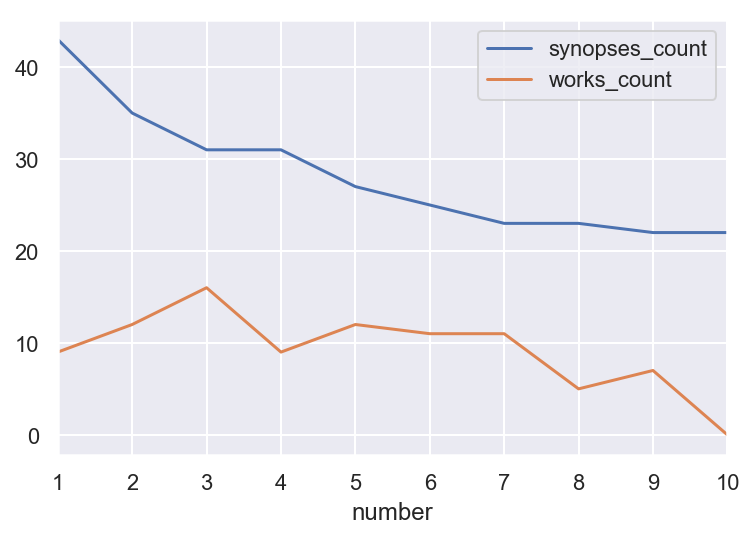

In [8]:
subjects.plot(x='number', y=['synopses_count', 'works_count'])

梗概数は回を増すごとに単調に減少している。  
第1回は43編が提出されていたが、第9・10回は約半数の22編である。  
11月(第6回)に聴講生から受講生に変わった人が3名ほどいるため、実質半数を切っている。

実作提出数は増えたり減ったりであるが、やはり序盤の方が少し多い。

ちなみに、梗概・実作の提出総数は次のとおりである。

In [9]:
subjects[['synopses_count', 'works_count']].sum()

synopses_count    282
works_count        92
dtype: int64

## 選出・得点機会

脱落してしまう理由はいろいろあると思うが、一つに徹底した実力主義があるだろう。  

提出した梗概は審査され、全提出作から3または4編だけが選出される。  
そして、選出されたとしても、また次回に実作で点数を競うことになる。

講義の時間は選出作品に多く割かれ、講師の評価が低ければほとんど言及されないことも珍しくない。  
仮に競争を意識していなかったとしても、提出した作品が講義で取り上げられないことが続くとつらいものがある。

この節では、そうした梗概の選出・実作の得点機会についてみる。

In [10]:
%%sql student_synopses <<

select
    name
    , submitted_count
    , selected_count
    , coalesce(characters_sum / submitted_count::real, 0) as characters_ave
    , coalesce(max_character_count, 0) as max_character_count
    , coalesce(appeal_characters_sum / submitted_count::real, 0) as appeal_characters_ave
    , coalesce(max_appeal_character_count, 0) as max_appeal_character_count
from
    (
        select
            s.original_id
            , s.name
            , count(sy.id) as submitted_count
            , sum(case when sy.selected then 1 else 0 end) as selected_count
            , sum(sy.character_count) as characters_sum
            , max(sy.character_count) as max_character_count
            , sum(sy.appeal_character_count) as appeal_characters_sum
            , max(sy.appeal_character_count) as max_appeal_character_count
        from
            students s
            join students_terms st on s.id = st.student_id
            left join (
                select
                    sy.*
                from
                    synopses sy
                    join subjects su on (
                        sy.subject_id = su.id
                        and su.term_id = :term_id
                    )
            ) sy on s.id = sy.student_id
        where
            st.term_id = :term_id
        group by
            1, 2
    ) student_synopses
order by
    original_id

 * postgresql://fuji-nakahara@localhost/genron-school-sf-app_development
Returning data to local variable student_synopses


In [11]:
%%sql student_works <<

select
    name
    , submitted_count
    , submitted_count - selected_count as optional_count
    , coalesce(score, 0) as score
    , optional_score
    , coalesce(characters_sum, 0) as characters_sum
from
    (
        select
            s.original_id
            , s.name
            , count(w.id) as submitted_count
            , sum(case when w.selected = True then 1 else 0 end) as selected_count
            , sum(w.score) as score
            , sum(case when w.selected != True then w.score else 0 end) as optional_score
            , sum(w.character_count) as characters_sum
        from
            students s
            join students_terms st on s.id = st.student_id
            left join (
                select
                    w.*
                    , sy.selected
                from
                    works w
                    join subjects su on (
                        w.subject_id = su.id
                        and su.term_id = :term_id
                    )
                    left join synopses sy using (original_id)
            ) w on s.id = w.student_id
        where
            st.term_id = :term_id
        group by
            1, 2
    ) student_synopses
order by
    original_id

 * postgresql://fuji-nakahara@localhost/genron-school-sf-app_development
Returning data to local variable student_works


### 梗概の提出・選出回数

受講生1人あたりの梗概提出回数・選出回数を調べてみよう。

In [12]:
student_synopses[['submitted_count', 'selected_count']].describe()

,submitted_count,selected_count
count,48.000000,48.000000
mean,5.875000,0.687500
std,3.600384,1.113863
min,0.000000,0.000000
25%,2.000000,0.000000
50%,6.000000,0.000000
75%,10.000000,1.000000
max,10.000000,4.000000


48人の受講生について、梗概提出回数 (submitted_count) の平均値は5.87回、中央値は6回である。  
それに対し、選出回数 (selected_count) は平均0.69回、中央値に至っては0回であった。  
つまり、半数以上の受講生が一度も選出されないのである。

分布にすると次のようになる。

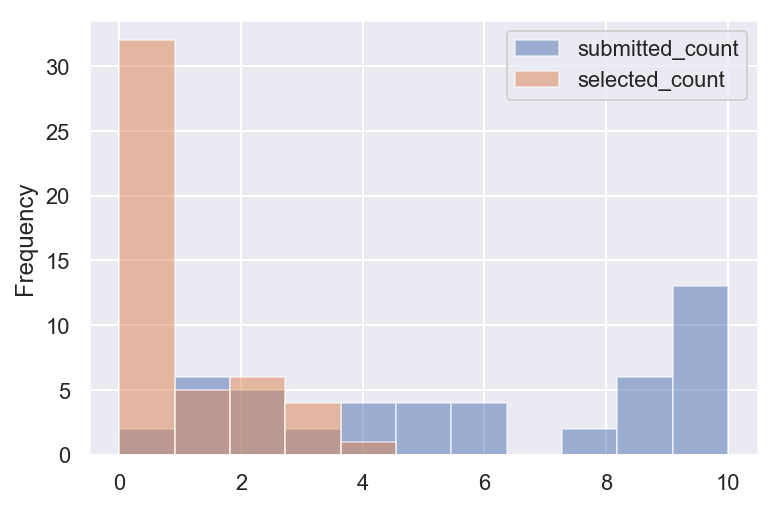

In [13]:
student_synopses[['submitted_count', 'selected_count']].plot.hist(bins=11, alpha=0.5)

オレンジ色が選出回数の分布である。  
1度も選出されていない受講生が32人おり、これは全体の32/48、すなわち3分の2である。  

また、青色が提出回数の分布である。  
これを見ると、10回、つまりすべての課題の梗概を提出した受講生が13人ほどいる。

### 実作提出数・自主提出数

同じように実作についてもみてみよう。

基本的には、梗概を選出された受講生が次の回に実作を書くことになっている。  
しかし、選出されていなくても実作を提出することは許されており、これは自主提出と呼ばれている。  
自主提出の場合は、必ずしも点数がつくわけではない。

In [14]:
student_works[['submitted_count', 'optional_count']].describe()

,submitted_count,optional_count
count,48.000000,48.000000
mean,1.916667,1.312500
std,2.656452,2.105275
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,3.250000,2.250000
max,9.000000,7.000000


実作提出回数の平均は1.92回、自主提出回数の平均は1.31回だった。

提出回数の分布は次のようになる。

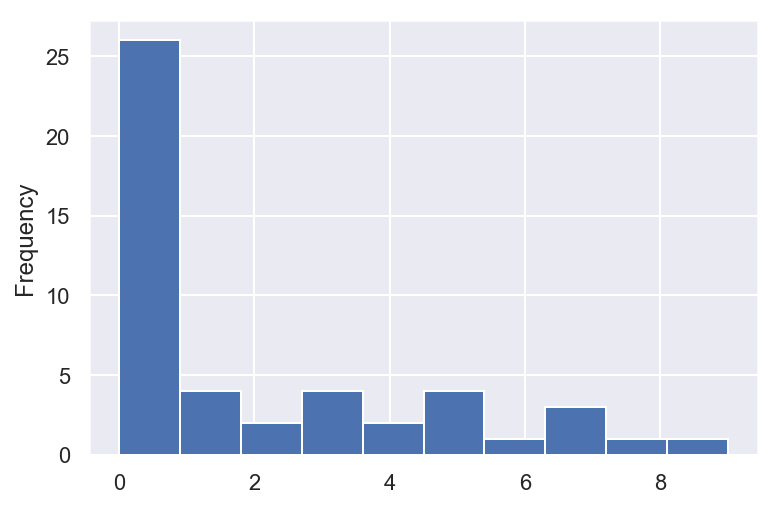

In [15]:
student_works.submitted_count.plot.hist(bins=10)

48人中26人、すなわち半数以上は1度も実作を提出していない。

また、自主提出作品の総数は次のとおりである。

In [16]:
student_works.optional_count.sum()

63

### 得点した自主提出作品

自主提出にはどのくらいの点数がつくのか。  
得点した自主提出作品はそれほど多くないので、すべてリストアップしてみよう。

In [17]:
%%sql

select
    su.number
    , su.title as subject_title
    , w.title as work_title
    , s.name as author
    , w.score
from
    works w
    join students s on w.student_id = s.id
    join subjects su on (
        w.subject_id = su.id
        and su.term_id = :term_id
    )
    join synopses sy on (w.original_id = sy.original_id)
where
    sy.selected != True
    and w.score > 0
order by
    1, s.original_id

 * postgresql://fuji-nakahara@localhost/genron-school-sf-app_development


,number,subject_title,work_title,author,score
0,1,AIあるいは仮想通貨を題材に短編を書け,子どもだましの森,遠山軌道,1
1,2,スキットがなきゃ意味がない,揺りかごの外から,遠山軌道,2
2,2,スキットがなきゃ意味がない,飲鴆止活（いんちんしかつ）,斧田 小夜,1
3,3,生き物を作ってみよう！,「蝗の王」,伊藤 元晴,2
4,3,生き物を作ってみよう！,肉のシャイロック,国分寺崖線,1
5,3,生き物を作ってみよう！,イキワカレノイモウト,進藤尚典,2
6,5,来たるべき読者のための「初めてのSF」,ナンバー・オブ・マイ・ルート,伊藤 元晴,1
7,5,来たるべき読者のための「初めてのSF」,はじめましてSci-Fiさん、エイリアンより,黒田 渚,1
8,5,来たるべき読者のための「初めてのSF」,ギークに銃はいらない,斧田 小夜,5
9,7,経過時間を設定してください,スシュランの男,斧田 小夜,2


自主提出63作中得点したのはたった14作である。  
14/63 = 0.22 ということで、4分の1未満の自主提出作品にしか点数はつかない。  
また、得点の最大値も5点となっている。

## 梗概の文字数

この節では、梗概の文字数についてみていく。

SF創作講座の課題には、梗概1200字以下、アピール文400字以下というルールがある。  
しかし、これはほとんど守られていない。  
そして、守っていない作品も選出される。  
むしろ、守っていない作品のほうが選出されやすいのではないか？  
多くの受講生が疑問思っているであろうこの問いに答えてみたい。

In [18]:
%%sql synopses_character_counts <<

select
    s.number
    , sy.title
    , st.name as author
    , sy.character_count
    , sy.appeal_character_count
    , sy.selected
from
    subjects s
    join synopses sy on s.id = sy.subject_id
    join students st on sy.student_id = st.id
where
    s.term_id = :term_id
    and s.number <= 9
order by
    1

 * postgresql://fuji-nakahara@localhost/genron-school-sf-app_development
Returning data to local variable synopses_character_counts


In [19]:
selected_synopses_character_counts = synopses_character_counts[synopses_character_counts.selected]

### 各種文字数の統計量

全梗概の文字数、全梗概のアピール文文字数、選出梗概の文字数、選出梗概のアピール文文字数のそれぞれについて平均や分散などの統計量をみる。

In [20]:
character_counts_with_selected = pd.DataFrame(
    {
        'character_count': synopses_character_counts.character_count,
        'selected_character_count': selected_synopses_character_counts.character_count,
        'appeal_character_count': synopses_character_counts.appeal_character_count.fillna(0),
        'selected_appeal_character_count': selected_synopses_character_counts.appeal_character_count.fillna(0)
    }
)

In [21]:
character_counts_with_selected.describe()

,character_count,selected_character_count,appeal_character_count,selected_appeal_character_count
count,260.000000,33.000000,260.000000,33.000000
mean,1433.761538,1580.969697,328.976923,340.575758
std,408.257088,525.927781,230.630158,173.437494
min,310.000000,1087.000000,0.000000,0.000000
25%,1196.750000,1198.000000,184.750000,255.000000
50%,1268.500000,1417.000000,319.500000,323.000000
75%,1599.250000,1798.000000,398.000000,400.000000
max,3714.000000,3714.000000,1967.000000,1035.000000


梗概の文字数 (character_count) の平均は1434字であるのに対し、選出梗概の文字数 (selected_character_count) の平均は1581字と約150字も多かった。  
アピール文についても、329字に対し、341字と10字ほど多い。  
もちろん、選出梗概のサンプル数が少なく、標準偏差も大きいため有意差はない。  
とはいえ、選出梗概の方が文字数が多いのではないか、という感覚が間違いではなさそうだ。

本文文字数の25パーセンタイルを見ると、1197字（選出梗概で1198字）となっており、約1/4の作品しか本文の文字数制約を守っていないことがわかる。
また、アピール文に関しては75パーセンタイルが400字ということで、約3/4がルールを守っている。

本文とアピール文の文字数の分布はそれぞれ次のようになる。

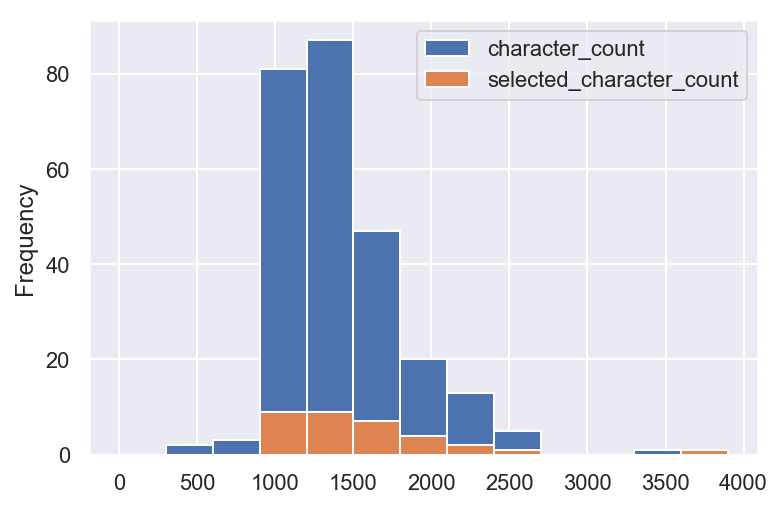

In [22]:
bins = list(range(0, character_counts_with_selected.character_count.max() + 300, 300))
character_counts_with_selected[['character_count', 'selected_character_count']].plot.hist(bins=bins)

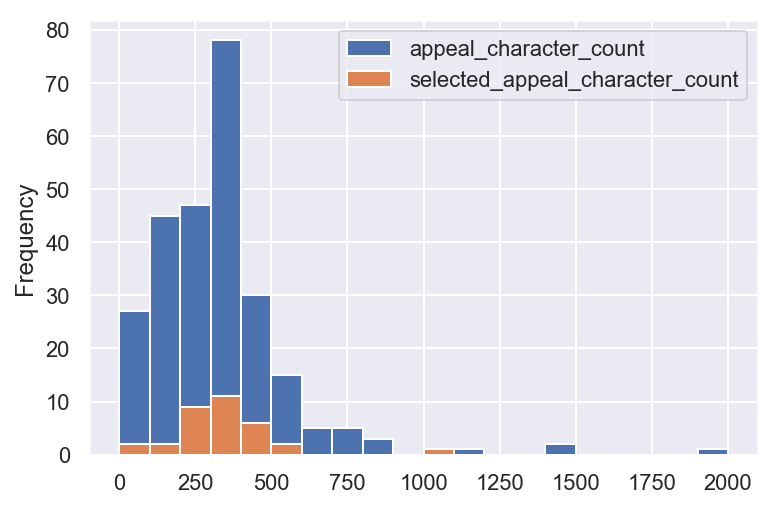

In [23]:
bins = list(range(0, int(character_counts_with_selected.appeal_character_count.max()) + 100, 100))
character_counts_with_selected[['appeal_character_count', 'selected_appeal_character_count']].plot.hist(bins=bins)

### 文字数順の選出梗概

選出梗概はそもそも33編しかないので、一覧しても大した量ではない。  
せっかくなので、本文文字数の少ない順に並べておく。

In [24]:
selected_synopses_character_counts.sort_values(by='character_count')

,number,title,author,character_count,appeal_character_count,selected
251,9,最古にして最新の弔い作法,小野 十郎,1087,224.0,True
234,8,酔来酔去,斧田 小夜,1126,255.0,True
180,6,フィオナの空、ロアの海,斧田 小夜,1148,340.0,True
83,3,死者の裔,武見 倉森,1154,248.0,True
10,1,これからの祈りについて,斧田 小夜,1168,327.0,True
7,1,AI、無人島を脱出できず,進藤尚典,1179,289.0,True
103,3,流星雨があがったら,揚羽はな,1196,296.0,True
155,5,暴走ロケットに乗れ！,揚羽はな,1198,276.0,True
9,1,涜神のスティグマ,維嶋津/いしましん,1198,393.0,True
41,1,暗点,国分寺崖線,1200,394.0,True


### 課題ごとの梗概文字数

次に、課題ごとの梗概文字数の分布を見ておこう。  
もしかすると、1200字のルールを守ったものしか選出しないゲスト講師がいるかも知れない。

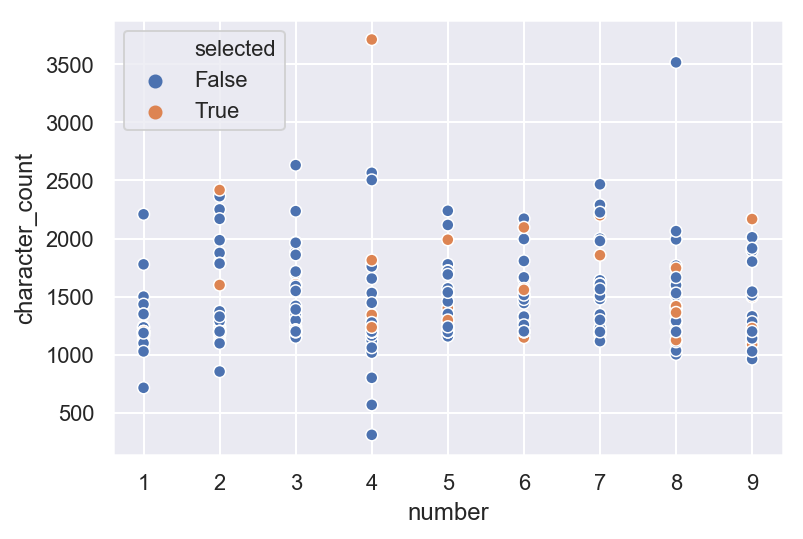

In [25]:
sns.scatterplot(x='number', y='character_count', hue='selected', data=synopses_character_counts)

横軸が課題の番号、縦軸が文字数で、ひとつひとつの作品がドットでプロットされている。  
選出された梗概はドットがオレンジ色になっている。

ただ、これではドットの重なりが多くわかりにくいので、重なった部分を横に広げたのが下の図である。

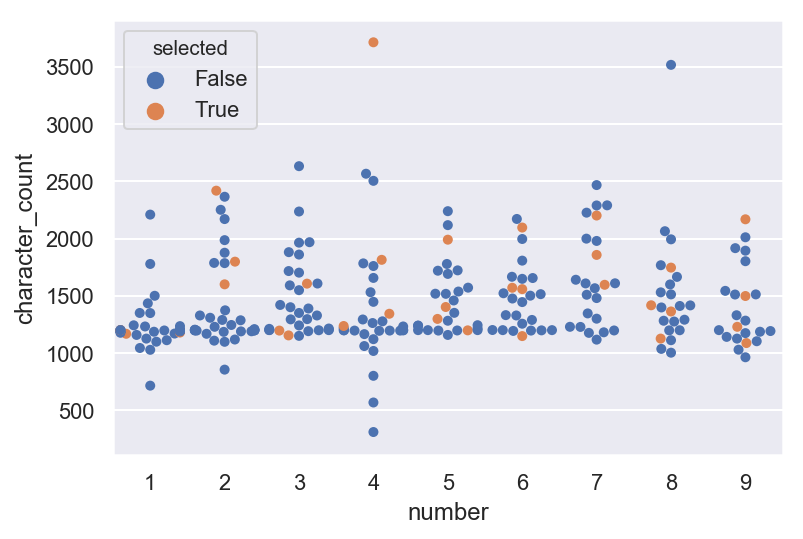

In [26]:
sns.swarmplot(x='number', y='character_count', hue='selected', data=synopses_character_counts)

すべての選出作が1200字を下回ったのは第1回だけだった。

## 受講生勝手にランキング

ここからは趣向を変えて、3期のようすを知っている人向けのデータを紹介する。  
SF創作講座では得点が絶対唯一の指標であるが、ここではそれ以外の数値について受講生を勝手にランキングしていこうと思う。

### 梗概

まずは、梗概に関するランキングである。  
データとして以下の表を用いる。

In [27]:
student_synopses

,name,submitted_count,selected_count,characters_ave,max_character_count,appeal_characters_ave,max_appeal_character_count
0,伊藤 元晴,10,2,1431.000000,1746,194.500000,383
1,亜月,6,0,1161.333333,1716,241.833333,352
2,甘木 零,9,1,1490.333333,1860,582.333333,1035
3,茶里 裕治,10,1,1803.100000,3714,239.500000,375
4,遠山軌道,9,1,1502.888889,2168,241.222222,688
5,篠田 航平,8,0,1487.125000,1876,338.875000,544
6,夢想 真,10,0,1346.900000,1531,211.400000,507
7,フジ・ナカハラ,6,3,1472.333333,2239,410.666667,471
8,宿禰,6,1,1946.666667,3517,289.000000,371
9,灰田 頼人,5,0,1545.600000,2566,208.600000,382


#### 梗概提出皆勤賞

全10回すべての梗概を提出した13名は次のとおりである。

In [28]:
student_synopses[student_synopses.submitted_count == 10][['name', 'submitted_count']]

,name,submitted_count
0,伊藤 元晴,10
3,茶里 裕治,10
6,夢想 真,10
19,武見 倉森,10
21,国分寺崖線,10
25,谷 美里,10
27,諸根 いつみ,10
34,進藤尚典,10
39,野咲タラ,10
41,安藤 タカシ,10


#### 文字数遵守

10回すべての梗概を提出しながらも、梗概とアピール文の文字数制限をすべて守った受講生が、なんと一人だけいた。  
揚羽はなさんである。

ちなみに梗概を4回以上提出した人に範囲を広げてもただ1人である。

In [29]:
student_synopses \
    [(student_synopses.max_character_count <= 1200) & (student_synopses.submitted_count >= 4)] \
    [['name', 'submitted_count', 'max_character_count']] \
    .sort_values(by='max_character_count').head()

,name,submitted_count,max_character_count
44,揚羽はな,10,1200


#### 5回以上の提出で平均文字数1200字以下

毎回守ったわけではないが、過半数の課題を提出したうえで、それらの文字数を平均すると1200字以下になる受講生は次のとおりである。

In [30]:
student_synopses \
    [(student_synopses.characters_ave <= 1200) & (student_synopses.submitted_count >= 5)] \
    [['name', 'submitted_count', 'characters_ave']] \
    .sort_values(by='characters_ave')

,name,submitted_count,characters_ave
39,野咲タラ,10,1139.500000
37,げんなり,9,1140.555556
1,亜月,6,1161.333333
44,揚羽はな,10,1197.600000


#### 文字数超過ワースト5

逆に、文字数制限を一切守る気のない、平均文字数のもっとも大きい人たちは次のとおりである。

In [31]:
student_synopses[student_synopses.submitted_count >= 2][['name', 'submitted_count', 'characters_ave']] \
    .sort_values(by='characters_ave', ascending=False).head()

,name,submitted_count,characters_ave
25,谷 美里,10,2002.800000
8,宿禰,6,1946.666667
21,国分寺崖線,10,1933.200000
3,茶里 裕治,10,1803.100000
45,ヤナギサワ カズキ,9,1699.777778


#### 梗概選出回数

3回以上梗概を選出されたのは5人、うち4回選出されたのは斧田 小夜さん1人だった。

In [32]:
student_synopses[student_synopses.selected_count >= 3][['name', 'selected_count']] \
    .sort_values(by='selected_count', ascending=False)

,name,selected_count
43,斧田 小夜,4
7,フジ・ナカハラ,3
16,維嶋津/いしましん,3
29,小野 十郎,3
47,琴柱遥,3


#### 梗概選出率

しかし、梗概選出回数を提出回数で割った「梗概選出率」でみると、1位は私になる。  
「受講生勝手にランキング」などと言いながら、これがやりたかっただけである。  
ちなみに、選出実作1編あたりの得点でランキングをつくった場合は、私がワースト1位になってしまう。

In [33]:
selected_rate = (student_synopses.selected_count / student_synopses.submitted_count).fillna(0)
selected_rate.name = 'selected_rate'
pd.concat([student_synopses, selected_rate], axis=1)\
    [['name', 'submitted_count', 'selected_count', 'selected_rate']] \
    .sort_values(by='selected_rate', ascending=False).head()

,name,submitted_count,selected_count,selected_rate
7,フジ・ナカハラ,6,3,0.500000
43,斧田 小夜,10,4,0.400000
29,小野 十郎,8,3,0.375000
16,維嶋津/いしましん,9,3,0.333333
47,琴柱遥,10,3,0.300000


### 実作

つぎは、実作に関するランキングをみていこう。  
データとして用いるのは以下の表である。

In [34]:
student_works

,name,submitted_count,optional_count,score,optional_score,characters_sum
0,伊藤 元晴,7,5,22,3,119855
1,亜月,0,0,0,0,0
2,甘木 零,7,6,8,3,101547
3,茶里 裕治,1,0,7,0,54
4,遠山軌道,4,4,3,3,83332
5,篠田 航平,0,0,0,0,0
6,夢想 真,0,0,0,0,0
7,フジ・ナカハラ,2,0,2,0,33434
8,宿禰,3,2,11,0,43795
9,灰田 頼人,0,0,0,0,0


#### 実作提出回数

実作提出回数トップ5は次のとおりである。  
斧田さんは実作も皆勤賞だった。

In [35]:
student_works[student_works.submitted_count >= 7][['name', 'submitted_count']] \
    .sort_values(by='submitted_count', ascending=False)

,name,submitted_count
43,斧田 小夜,9
34,進藤尚典,8
0,伊藤 元晴,7
2,甘木 零,7
39,野咲タラ,7


#### 自主提出得点

点数の入りにくい自主提出の得点だけでランキングすると、トップ5は次のようになる。  
ここでも斧田さんが1位。

In [36]:
student_works[student_works.optional_score >= 3][['name', 'optional_score']] \
    .sort_values(by='optional_score', ascending=False)

,name,optional_score
43,斧田 小夜,11
27,諸根 いつみ,4
0,伊藤 元晴,3
2,甘木 零,3
4,遠山軌道,3


#### 実作総文字数

最後に、実作の総文字数トップ5である。  
当然斧田さんが1位。だんとつの20万字である。

In [37]:
student_works[['name', 'characters_sum']].sort_values(by='characters_sum', ascending=False).head()

,name,characters_sum
43,斧田 小夜,194215
0,伊藤 元晴,119855
34,進藤尚典,103795
2,甘木 零,101547
47,琴柱遥,100798


---

実作に関する数字は斧田さんが圧倒的であった。  
それでも、総得点は琴柱遥さんが1位である。  
星新一賞の一般部門優秀賞を受賞し、ただひとり文字数を遵守した揚羽さんにも注目したい。

はたして、ゲンロンSF新人賞は誰の手に渡るのか。